## Setup

In [98]:
import cv2
import csv
import os
import numpy as np
import matplotlib.pyplot as plt

In [99]:
IMG_A_PATH = "./homography_rgb.jpg"   # Source image (A)
IMG_B_PATH = "./homography_thermal.png"       # Destination/reference image (B)
# IMG_B_PATH = "./depth-full-c.png"   # Source image (B2)

ALPHA = 0.5             # 0..1 for alpha blend
SWIPE_FRACTION = 0.5    # 0..1 for left-to-right wipe
POINT_RADIUS = 5

CSV_A = os.path.splitext(os.path.basename(IMG_A_PATH))[0] + "_points.csv"
CSV_B = os.path.splitext(os.path.basename(IMG_B_PATH))[0] + "_points.csv"

# Utility

In [100]:
def save_points_csv(csv_path, pts):
    """Save list of (x,y) to CSV."""
    with open(csv_path, "w", newline="") as f:
        w = csv.writer(f)
        w.writerow(["idx","x","y"])
        for i, (x, y) in enumerate(pts, 1):
            w.writerow([i, int(x), int(y)])
    print(f"Saved {len(pts)} points to {csv_path}")

def load_points_csv(csv_path):
    """Load (x,y) points from CSV if file exists."""
    pts = []
    if os.path.exists(csv_path):
        try:
            with open(csv_path, "r", newline="") as f:
                r = csv.reader(f)
                header = next(r, None)
                for row in r:
                    if len(row) >= 3:
                        pts.append((int(float(row[1])), int(float(row[2]))))
            print(f"Loaded {len(pts)} points from {csv_path}")
        except Exception as e:
            print(f"Failed to load {csv_path}: {e}")
            pts = []
    return pts

# Points Picker

In [101]:
def pick_points_on_image_window(img_path, initial_pts=None, win_name=None):
    """
    Open an interactive OpenCV window for picking points.
    Controls:
      - Left click: add point
      - Right click: remove nearest (within 10px)
      - 'u': undo
      - 'c': clear
      - 's': save
      - 'q' or ESC: finish
    """
    img = cv2.imread(img_path)
    if img is None:
        raise FileNotFoundError(img_path)

    pts = list(initial_pts) if initial_pts else []
    font = cv2.FONT_HERSHEY_SIMPLEX
    win = win_name or f"Pick Points: {os.path.basename(img_path)}"

    def draw_overlay():
        vis = img.copy()
        for i,(u,v) in enumerate(pts, start=1):
            cv2.circle(vis, (u,v), POINT_RADIUS, (0,255,0), -1)
            cv2.putText(vis, f"{i}", (u+8, v-8), font, 0.5, (0,255,0), 1, cv2.LINE_AA)
        cv2.putText(vis, "L-click=add, R-click=remove, u=undo, c=clear, s=save, q/ESC=finish",
                    (10, 20), font, 0.5, (0,200,0), 1, cv2.LINE_AA)
        return vis

    def nearest_idx(u0, v0):
        if not pts: return -1, 1e18
        d2 = [(u-u0)**2 + (v-v0)**2 for (u,v) in pts]
        j = int(np.argmin(d2))
        return j, d2[j]

    cv2.namedWindow(win, cv2.WINDOW_AUTOSIZE)
    cv2.imshow(win, draw_overlay())

    def on_mouse(event, x, y, flags, param):
        if event == cv2.EVENT_LBUTTONDOWN:
            pts.append((x,y))
            print(f"[{win}] + #{len(pts)}: ({x},{y})")
            cv2.imshow(win, draw_overlay())
        elif event == cv2.EVENT_RBUTTONDOWN:
            j, d2 = nearest_idx(x,y)
            if j != -1 and d2 <= 10**2:
                removed = pts.pop(j)
                print(f"[{win}] - {removed}")
                cv2.imshow(win, draw_overlay())

    cv2.setMouseCallback(win, on_mouse)

    while True:
        key = cv2.waitKey(20) & 0xFF
        if key in (27, ord('q')):
            break
        elif key == ord('u'):
            if pts:
                print(f"[{win}] undo:", pts.pop())
                cv2.imshow(win, draw_overlay())
        elif key == ord('c'):
            pts.clear()
            print(f"[{win}] cleared")
            cv2.imshow(win, draw_overlay())
        elif key == ord('s'):
            save_points_csv(os.path.splitext(os.path.basename(img_path))[0] + "_points.csv", pts)
            cv2.imshow(win, draw_overlay())

    cv2.destroyWindow(win)
    return np.array(pts, dtype=np.float32)

## Compute Homography and Visualize

In [102]:
def compute_h_and_warp(imgA_path, imgB_path, ptsA, ptsB):
    """Compute H mapping A→B, warp A, and return (H, warpedA, imgA, imgB)."""
    if len(ptsA) < 4 or len(ptsB) < 4 or len(ptsA) != len(ptsB):
        raise ValueError("Need >=4 corresponding points in both images (equal count).")
    H, mask = cv2.findHomography(
        ptsA, ptsB,
    )
    print("Homography H:\n", H)
    print("Inliers:", int(mask.sum()), "/", len(mask))

    imgA = cv2.imread(imgA_path)
    imgB = cv2.imread(imgB_path)
    if imgA is None or imgB is None:
        raise FileNotFoundError("Could not read input images.")
    hB, wB = imgB.shape[:2]
    warpedA = cv2.warpPerspective(imgA, H, (wB, hB))
    return H, warpedA, imgA, imgB

def bgr2rgb(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def show_and_save_overlays(warpedA, imgB, alpha=ALPHA, swipe_frac=SWIPE_FRACTION):
    """Show overlay visualizations in a 2×2 grid inline (no OpenCV pop-ups)."""
    h, w = imgB.shape[:2]

    # 1. Alpha blend
    overlay = cv2.addWeighted(imgB, 1.0 - alpha, warpedA, alpha, 0)
    cv2.imwrite("overlay_alpha.jpg", overlay)

    # 2. Swipe split
    swipe = imgB.copy()
    split = int(w * swipe_frac)
    swipe[:, :split] = warpedA[:, :split]
    cv2.imwrite("overlay_swipe.jpg", swipe)

    # --- Inline visualization in 2×2 grid ---
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 2, 1)
    plt.imshow(bgr2rgb(imgB))
    plt.title("Destination (reference)")
    plt.axis("off")

    plt.subplot(2, 2, 2)
    plt.imshow(bgr2rgb(warpedA))
    plt.title("Warped Source → Destination frame")
    plt.axis("off")

    plt.subplot(2, 2, 3)
    plt.imshow(bgr2rgb(overlay))
    plt.title(f"Alpha overlay (α={alpha:.2f})")
    plt.axis("off")

    plt.subplot(2, 2, 4)
    plt.imshow(bgr2rgb(swipe))
    plt.title(f"Swipe overlay (fraction={swipe_frac:.2f})")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

    print("Saved: overlay_alpha.jpg, overlay_swipe.jpg")


# Run Full Workflow

Loaded 8 points from homography_rgb_points.csv
Loaded 8 points from homography_thermal_points.csv

--- Select points in Image A (source) ---

--- Select points in Image B (destination) ---
Saved 8 points to homography_rgb_points.csv
Saved 8 points to homography_thermal_points.csv
Homography H:
 [[ 1.45736947e+00 -2.03746579e-01  6.18371984e+01]
 [ 2.13552286e-01  1.02802498e+00 -1.38943389e+01]
 [ 1.29837733e-03 -3.73913646e-04  1.00000000e+00]]
Inliers: 8 / 8
Saved: warped_A_to_B.jpg


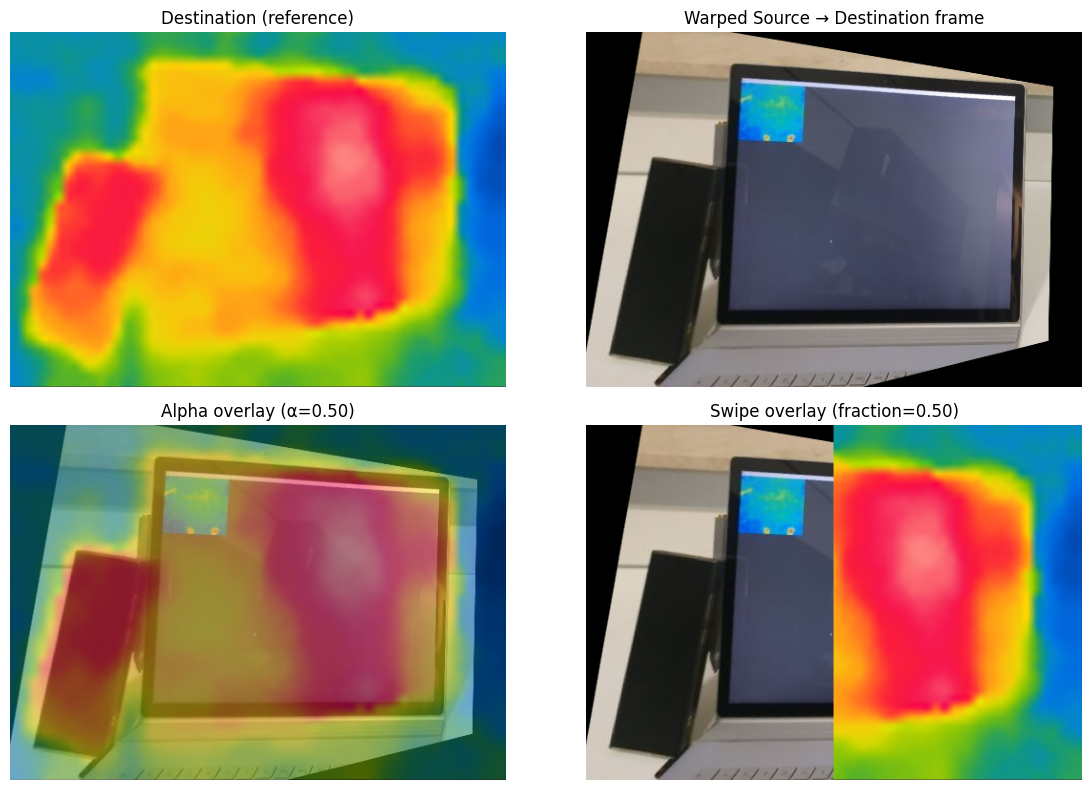

Saved: overlay_alpha.jpg, overlay_swipe.jpg


In [103]:
# Load previous selections if available
ptsA_init = load_points_csv(CSV_A)
ptsB_init = load_points_csv(CSV_B)

# Step 1: Pick points in source (A)
print("\n--- Select points in Image A (source) ---")
ptsA = pick_points_on_image_window(IMG_A_PATH, initial_pts=ptsA_init, win_name="Image A (source)")

# Step 2: Pick points in destination (B)
print("\n--- Select points in Image B (destination) ---")
ptsB = pick_points_on_image_window(IMG_B_PATH, initial_pts=ptsB_init, win_name="Image B (destination)")

# Step 3: Save the picked points
save_points_csv(CSV_A, ptsA)
save_points_csv(CSV_B, ptsB)

# Step 4: Compute Homography and visualize
H, warpedA, imgA, imgB = compute_h_and_warp(IMG_A_PATH, IMG_B_PATH, ptsA, ptsB)
cv2.imwrite("warped_A_to_B.jpg", warpedA)
print("Saved: warped_A_to_B.jpg")

# Step 5: Overlay visualization
show_and_save_overlays(warpedA, imgB, alpha=ALPHA, swipe_frac=SWIPE_FRACTION)